In [1]:
import numpy as np
import ROOT

strobe_res=np.array(
[[10000, 25000, 1    ],    
 [10000, 45000, 4469 ],   
 [10000, 65000, 3208 ],   
 [15000, 25000, 9242 ],    
 [15000, 45000, 6210 ],   
 [15000, 65000, 4516 ],   
 [20000, 25000, 10881],   
 [20000, 45000, 7397 ],  
 [20000, 65000, 5654 ],  
 [25000, 25000, 12090],  
 [25000, 45000, 8705 ],   
 [25000, 65000, 6624 ],    
 [30000, 45000, 9518 ],  
 [30000, 65000, 7664 ],  
 [35000, 45000, 10547], 
 [35000, 65000, 8536 ],  
 [40000, 45000, 11615], 
 [40000, 65000, 9052 ], 
 [45000, 45000, 12025],  
 [45000, 65000, 9857 ],  
 [50000, 65000, 10418],  
 [5000 , 25000, 1    ], 
 [5000 , 45000, 2516 ], 
 [5000 , 65000, 1797 ],   
 [55000, 65000, 10886],   
 [60000, 65000, 11562], 
 [65000, 65000, 11967]] )

print(strobe_res)

Welcome to JupyROOT 6.20/06
[[10000 25000     1]
 [10000 45000  4469]
 [10000 65000  3208]
 [15000 25000  9242]
 [15000 45000  6210]
 [15000 65000  4516]
 [20000 25000 10881]
 [20000 45000  7397]
 [20000 65000  5654]
 [25000 25000 12090]
 [25000 45000  8705]
 [25000 65000  6624]
 [30000 45000  9518]
 [30000 65000  7664]
 [35000 45000 10547]
 [35000 65000  8536]
 [40000 45000 11615]
 [40000 65000  9052]
 [45000 45000 12025]
 [45000 65000  9857]
 [50000 65000 10418]
 [ 5000 25000     1]
 [ 5000 45000  2516]
 [ 5000 65000  1797]
 [55000 65000 10886]
 [60000 65000 11562]
 [65000 65000 11967]]


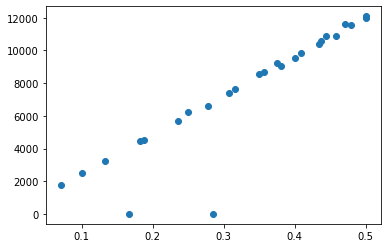

In [2]:
import matplotlib.pyplot as plt
x= strobe_res[:,0]/(strobe_res[:,0]+strobe_res[:,1])
y = strobe_res[:,2]

y1 = y[y>1]
x1 = x[y>1]
plt.scatter(x,y)

Slope    :  23963.92010303029
intercept:  74.46175547287385
r_value  :  0.9994207515742944
p_value  :  2.81794616396622e-35
std_err  :  170.14927813399854


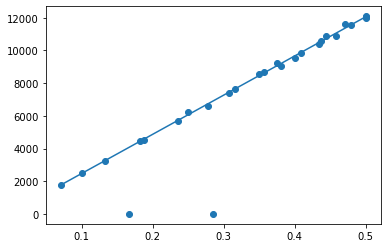

In [3]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x1,y1)

print("Slope    : ", slope     )
print("intercept: ", intercept ) 
print("r_value  : ", r_value   ) 
print("p_value  : ", p_value   )    
print("std_err  : ", std_err   )   
plt.scatter(x,y)
plt.plot(np.linspace(np.min(x),np.max(x),1000), np.linspace(np.min(x),np.max(x),1000)*slope + intercept)

In [4]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
#import tqdm as tqdm
import tqdm.notebook as tqdm
import multiprocessing

In [5]:
#Run packet analyzer script for all threshold
Data_folder_path="Data_Strobe_Test"

Run_Analysis = True
Force_Analysis = False\

files=os.listdir(Data_folder_path + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)
        if name.startswith('1min_'):
            root_file=Path("Analyzed_Data/"+name+"/"+name+".root")
            root_file_existence_flag=root_file.is_file()
            if (Run_Analysis and not root_file_existence_flag) or Force_Analysis:
                args = "-f "+name+" -Df "+Data_folder_path+" -p -d 3 15 "
                %run 'Packet_analyzer.py' {args}

In [22]:
#Noise and rate dependance on VCASN

Area_thr  = 12
Ratio_thr = 3.5

VCASN_val    = []
Noise_points = []
Counts       = []
Time_acq     = []
Strobe_par   = []
Mean_area    = []
Area_err     = []
Mean_PCAr    = []
PCAr_err     = []


files=os.listdir(Data_folder_path+"/")
with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)
        if name.startswith('1min_'):
            V_CASN_THR=int(name.split('_')[2], base=16)
            VCASN_val = np.append(VCASN_val,V_CASN_THR)

            file=open(Data_folder_path+"/"+name+"/Stat_"+name+".txt")
            line=file.readlines()
            for l in line:
                if (l.startswith("Readout_time")):
                    time=float(l.split('=')[1].strip()[:-1])
                if (l.startswith("Strobe")):
                    Strobe=int(l.split('=')[1].strip()[:-1])
                if (l.startswith("Gap")):
                    Gap=int(l.split('=')[1].strip()[:-1])

            filename="Analyzed_Data/"+name+"/"+name+".root"
            root_file_1  = ROOT.TFile.Open(filename)
            Data_tree    = root_file_1.Get("tree")
            Noise        = Data_tree.AsMatrix(['Rnoise'])
            Areas        = Data_tree.AsMatrix(['Rareas'])
            Ratios       = Data_tree.AsMatrix(['Rratios'])

            mask_thr   = np.logical_and (np.squeeze(Areas)      > Area_thr, np.squeeze(Ratios)     < Ratio_thr)
            Counts     = np.append(Counts,len(Areas [mask_thr]))
            Time_acq   = np.append(Time_acq, time)
            Strobe_par = np.append(Strobe_par, Strobe/(Strobe+Gap))
            Mean_area  = np.append(Mean_area,np.mean(Areas [mask_thr]))
            Area_err   = np.append(Area_err,np.std(Areas [mask_thr]))
            Mean_PCAr  = np.append(Mean_PCAr,np.mean(Ratios [mask_thr]))
            PCAr_err   = np.append(PCAr_err,np.std(Ratios [mask_thr]))


            Noise_points_rate = np.append(Noise_points,(Noise[0]+len(Areas[np.invert(mask_thr)]))/time)
        

/home/gabriele/anaconda3/envs/rootenv/lib/python3.8/site-packages/ROOT.py:352: FutureWarning: Instantiating a function template with parentheses ( f(type1, ..., typeN) ) is deprecated and will not be supported in a future version of ROOT. Instead, use square brackets: f[type1, ..., typeN]
  flat_matrix_ptr = _root.ROOT.Internal.RDF.GetVectorAddress(dtype)(flat_matrix)
/home/gabriele/anaconda3/envs/rootenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gabriele/anaconda3/envs/rootenv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gabriele/anaconda3/envs/rootenv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gabriele/anaconda3/envs/rootenv/lib/python

In [23]:
mask_good       = np.greater_equal(Counts, np.ones(len(Counts))*10)

Counts_corr     = Counts     [mask_good]
Time_acq_corr   = Time_acq   [mask_good]
Strobe_par_corr = Strobe_par [mask_good]
Mean_area_corr  = Mean_area  [mask_good]
Area_err_corr   = Area_err   [mask_good]
Mean_PCAr_corr  = Mean_PCAr  [mask_good]
PCAr_err_corr   = PCAr_err   [mask_good]

Rate_corr       = Counts_corr/Time_acq_corr
Rate_err_corr   = np.sqrt(Counts_corr)/Time_acq_corr

In [24]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a+b*x

popt, pcov = curve_fit(linear, xdata=Strobe_par_corr, ydata=Rate_corr, sigma=Rate_err_corr)

In [25]:
print('Intercept = %f +- %f' % (popt[0], np.sqrt(pcov[0,0])))
print('Slope     = %f +- %f' % (popt[1], np.sqrt(pcov[1,1])))

print('Intercept = %f +- %f' % (popt[0]*3600, np.sqrt(pcov[0,0])*3600))
print('Slope     = %f +- %f' % (popt[1]*3600, np.sqrt(pcov[1,1])*3600))

Intercept = 0.939956 +- 0.567121
Slope     = 317.762605 +- 1.887946
Intercept = 3383.841834 +- 2041.635675
Slope     = 1143945.379214 +- 6796.605181



****************************************
Minimizer is Linear / Migrad
Chi2                      =      54.6534
NDf                       =           23
p0                        =      0.74767   +/-   0.8765      
p1                        =      318.384   +/-   2.39672     


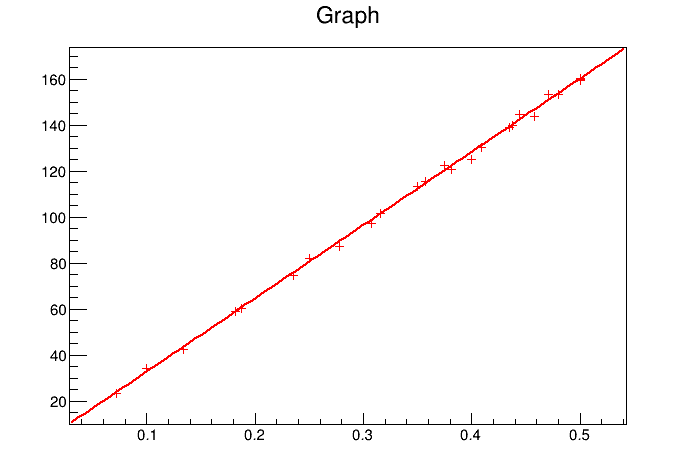

In [26]:
xr    = np.array(Strobe_par_corr, dtype=float)
yr    = np.array(Rate_corr  , dtype=float)
nr    = len(xr)
graph = ROOT.TGraph(nr,xr,yr)

graph.SetMarkerStyle(2)
graph.SetMarkerColor(2)

lin = ROOT.TF1('lin','pol1')

lin.SetParameters(170,24000)
graph.Fit(lin)

cg = ROOT.TCanvas()
graph.Draw('AP')
cg.Draw()

In [27]:
import pandas as pd
import bokeh.palettes as palette
import matplotlib

In [28]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [29]:
col = palette.brewer['RdYlGn'][10]

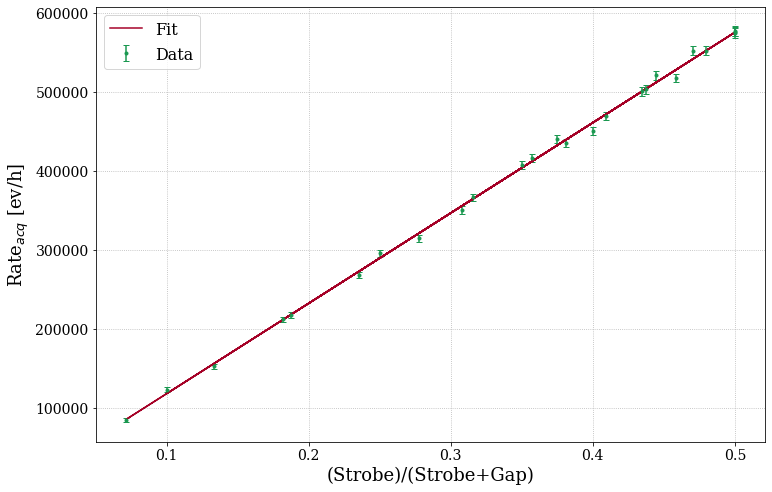

In [30]:
plt.figure(figsize=(12,8))
plt.errorbar(Strobe_par_corr,
             Rate_corr*3600,
             yerr            = Rate_err_corr*3600,
             fmt             = 'o',
             markerfacecolor = col[1],
             color           = col[1],
             ecolor          = col[1],
             label           = "Data",
             alpha           = 1,
             markersize      = 3,
             capsize         = 3) #fillstyle="none"

plt.plot(Strobe_par_corr,
         linear(Strobe_par_corr,popt[0],popt[1])*3600,
         color=col[9],
         label="Fit",
         alpha=1,
         markersize=3)

plt.xlabel("(Strobe)/(Strobe+Gap)")
plt.ylabel("Rate$_{acq}$ [ev/h]")

plt.grid(True, linestyle=':')
plt.legend()
plt.savefig("../Graph_images/Strobe_Test_py", dpi=200)
plt.show()

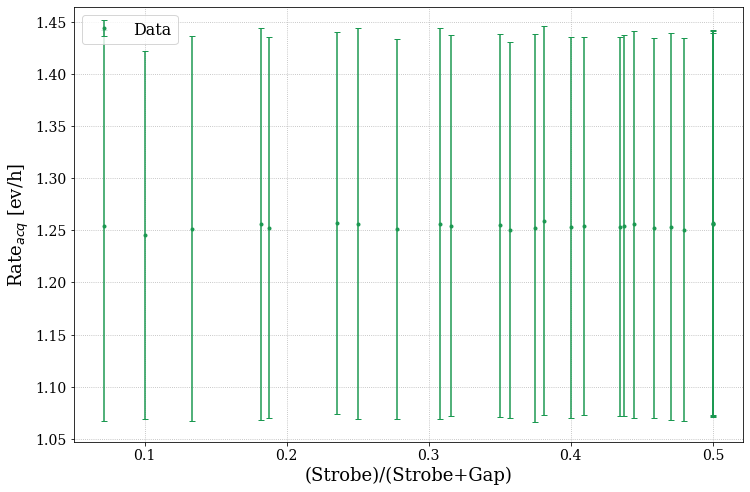

In [32]:
plt.figure(figsize=(12,8))
plt.errorbar(Strobe_par_corr,
             Mean_PCAr_corr,
             yerr            = PCAr_err_corr,
             fmt             = 'o',
             markerfacecolor = col[1],
             color           = col[1],
             ecolor          = col[1],
             label           = "Data",
             alpha           = 1,
             markersize      = 3,
             capsize         = 3) #fillstyle="none"



plt.xlabel("(Strobe)/(Strobe+Gap)")
plt.ylabel("Rate$_{acq}$ [ev/h]")

plt.grid(True, linestyle=':')
plt.legend()
#plt.savefig("../Graph_images/Strobe_Test_py", dpi=200)
plt.show()